**Compare character vs word tokenizer**

In [25]:
import os
import requests
import tokenization

SAMPLE_TEXT_FOLDER = "sample_texts"

if not os.path.exists(os.path.join(SAMPLE_TEXT_FOLDER, "the-verdict.txt")):
    url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"
    response = requests.get(url, timeout=30)
    with open(os.path.join(SAMPLE_TEXT_FOLDER, "the-verdict.txt"), "wb") as f:
        f.write(response.content)
    print("Downloaded the-verdict.txt")

with open(os.path.join(SAMPLE_TEXT_FOLDER, "the-verdict.txt"), "r", encoding="utf-8") as f:
    raw_text = f.read()

In [26]:
tokenizer = tokenization.WordTokenizer()
tokenizer.build_vocab(raw_text)

text = "Hello, do you like tea?"

enc_text = tokenizer.encode(text)
print(enc_text)
dec_text = tokenizer.decode(enc_text)
print(dec_text)


[1131, 5, 355, 1126, 628, 975, 10]
<|unk|>, do you like tea?


In [27]:
cTokenizer = tokenization.CharacterTokenizer()
cTokenizer.build_vocab(raw_text)

enc_text = cTokenizer.encode(text)
print(enc_text)
dec_text = cTokenizer.decode(enc_text)
print(dec_text)


[20, 40, 47, 47, 50, 7, 1, 39, 50, 1, 60, 50, 56, 1, 47, 44, 46, 40, 1, 55, 40, 36, 12]
Hello, do you like tea?


In [28]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
enc_text = tokenizer.encode(raw_text)

enc_sample = enc_text[50:]
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]
[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257
 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


In [29]:
dataloader = tokenization.create_dataloader(raw_text, batch_size=4, max_length=8, stride=2)

for batch in dataloader:
    x, y = batch
    print(f"x: {x}")
    print(f"y: {y}")
    break

x: tensor([[    0,   314,   373, 24380,   284,  3589,   588,   530],
        [  271, 10899,    11,   508,   550, 18459,  1068,   284],
        [  290,   339,  3724,  6451,    11,   286,  2612,  4369],
        [  470,  1011,   881,  2392,   284,  1645,    13,   764]])
y: tensor([[  314,   373, 24380,   284,  3589,   588,   530,   286],
        [10899,    11,   508,   550, 18459,  1068,   284,  1577],
        [  339,  3724,  6451,    11,   286,  2612,  4369,    11],
        [ 1011,   881,  2392,   284,  1645,    13,   764,   764]])


---

# Comparative Tokenization Analysis

In this section, we compare three tokenization methods:

1. **Character Tokenizer** - Splits text into individual characters. Simple but results in long sequences.
2. **Word Tokenizer** - Splits text by words and punctuation using regex patterns. Moderate vocabulary size.
3. **BPE Tokenizer (GPT-2)** - Byte Pair Encoding used by GPT-2. Balances vocabulary size and sequence length.

## Metrics We'll Compare:
- **Vocabulary Size**: Number of unique tokens in the tokenizer's vocabulary
- **Sequence Length**: Number of tokens produced for each text sample
- **Compression Ratio**: Characters per token (higher = more efficient)
- **OOV Coverage**: How the tokenizer handles out-of-vocabulary words

In [30]:
import importlib
importlib.reload(tokenization)

import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

# Load all sample texts
sample_files = ["the-verdict.txt", "ai-news.txt", "family.txt", "pytorch-doc.txt"]
sample_texts = {}

for filename in sample_files:
    filepath = os.path.join(SAMPLE_TEXT_FOLDER, filename)
    if os.path.exists(filepath):
        with open(filepath, "r", encoding="utf-8") as f:
            sample_texts[filename.replace(".txt", "")] = f.read()
        print(f"Loaded {filename}: {len(sample_texts[filename.replace('.txt', '')])} characters")

print(f"\nTotal samples loaded: {len(sample_texts)}")

Loaded the-verdict.txt: 20479 characters
Loaded ai-news.txt: 6918 characters
Loaded family.txt: 67091 characters
Loaded pytorch-doc.txt: 9661 characters

Total samples loaded: 4


## Initialize Tokenizers

We build vocabularies using the combined corpus from all sample texts. This ensures consistent vocabulary across comparisons.

In [31]:
# Combine all texts for building vocabulary
combined_corpus = " ".join(sample_texts.values())

# Initialize the three tokenizers
char_tokenizer = tokenization.CharacterTokenizer()
char_tokenizer.build_vocab(combined_corpus)

word_tokenizer = tokenization.WordTokenizer()
word_tokenizer.build_vocab(combined_corpus)

bpe_tokenizer = tiktoken.get_encoding("gpt2")

# Store tokenizers in a dict for easy iteration
tokenizers = {
    "Character": char_tokenizer,
    "Word": word_tokenizer,
    "BPE (GPT-2)": bpe_tokenizer
}

print("Tokenizer vocabularies built:")
print(f"  Character: {len(char_tokenizer.str_to_int)} unique characters")
print(f"  Word: {len(word_tokenizer.str_to_int)} unique words/tokens")
print(f"  BPE (GPT-2): {bpe_tokenizer.n_vocab} tokens (pre-trained vocabulary)")

Tokenizer vocabularies built:
  Character: 106 unique characters
  Word: 3609 unique words/tokens
  BPE (GPT-2): 50257 tokens (pre-trained vocabulary)


## Analysis Functions

These helper functions calculate the key metrics for comparing tokenization methods.

In [32]:
def get_vocab_size(tokenizer, name):
    """Get vocabulary size for a tokenizer."""
    if name == "BPE (GPT-2)":
        return tokenizer.n_vocab
    else:
        return len(tokenizer.str_to_int)

def tokenize_text(tokenizer, text, name):
    """Tokenize text with proper handling for each tokenizer type."""
    if name == "BPE (GPT-2)":
        return tokenizer.encode(text)
    else:
        return tokenizer.encode(text)

def calculate_compression_ratio(text, tokens):
    """Calculate compression ratio (characters per token)."""
    return len(text) / len(tokens) if tokens else 0

def count_oov_tokens(tokenizer, tokens, name):
    """Count out-of-vocabulary tokens."""
    if name == "BPE (GPT-2)":
        # BPE doesn't have OOV - it can encode any byte sequence
        return 0
    elif name == "Word":
        # Check for <|unk|> tokens in the vocabulary
        unk_id = tokenizer.str_to_int.get("<|unk|>")
        return tokens.count(unk_id) if unk_id else 0
    else:
        # Character tokenizer - count tokens not in vocabulary
        return sum(1 for t in tokens if t not in tokenizer.int_to_str)

def analyze_tokenization(text, text_name):
    """Analyze a text with all three tokenization methods."""
    results = []
    
    for tok_name, tokenizer in tokenizers.items():
        tokens = tokenize_text(tokenizer, text, tok_name)
        
        results.append({
            "Text": text_name,
            "Tokenizer": tok_name,
            "Vocab Size": get_vocab_size(tokenizer, tok_name),
            "Sequence Length": len(tokens),
            "Compression Ratio": calculate_compression_ratio(text, tokens),
            "OOV Count": count_oov_tokens(tokenizer, tokens, tok_name),
            "Char Count": len(text)
        })
    
    return results

print("Analysis functions defined successfully.")

Analysis functions defined successfully.


## Run Comparative Analysis

Tokenize each sample text with all three methods and collect metrics.

In [33]:
# Run analysis on all sample texts
all_results = []

for text_name, text in sample_texts.items():
    results = analyze_tokenization(text, text_name)
    all_results.extend(results)

# Create DataFrame for easy analysis
df = pd.DataFrame(all_results)

# Display results table
print("=== Comparative Tokenization Analysis ===\n")
display(df.pivot_table(
    index='Text', 
    columns='Tokenizer', 
    values=['Sequence Length', 'Compression Ratio', 'OOV Count'],
    aggfunc='first'
).round(2))

=== Comparative Tokenization Analysis ===



Compression Ratio                   OOV Count                 \
Tokenizer         BPE (GPT-2) Character  Word BPE (GPT-2) Character Word   
Text                                                                       
ai-news                  4.89       1.0  5.78           0         0    0   
family                   4.11       1.0  5.22           0         0    0   
pytorch-doc              2.40       1.0  4.11           0         0    0   
the-verdict              3.98       1.0  4.37           0         0    0   

            Sequence Length                   
Tokenizer       BPE (GPT-2) Character   Word  
Text                                          
ai-news                1415      6918   1197  
family                16305     67091  12841  
pytorch-doc            4023      9661   2351  
the-verdict            5145     20479   4690

---

# Visualization

## Bar Charts: Comparing Metrics Across Methods

These visualizations show how each tokenization method performs across different metrics.

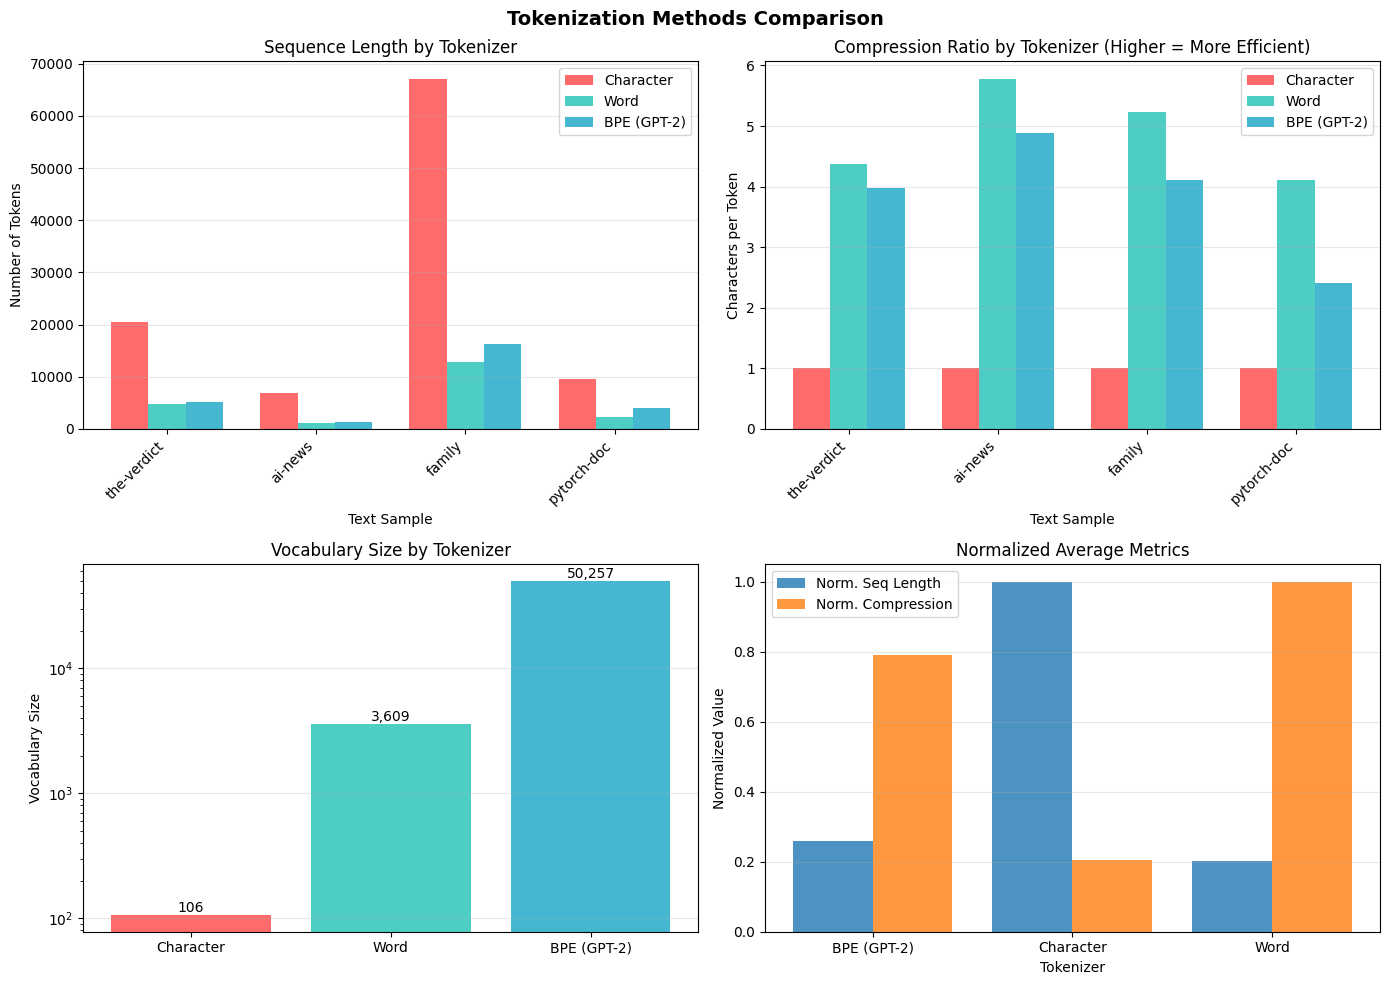

In [34]:
# Set up the figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Tokenization Methods Comparison', fontsize=14, fontweight='bold')

colors = {'Character': '#FF6B6B', 'Word': '#4ECDC4', 'BPE (GPT-2)': '#45B7D1'}
texts = list(sample_texts.keys())
x = np.arange(len(texts))
width = 0.25

# 1. Sequence Length Comparison
ax1 = axes[0, 0]
for i, tok_name in enumerate(tokenizers.keys()):
    seq_lengths = df[df['Tokenizer'] == tok_name]['Sequence Length'].values
    ax1.bar(x + i*width, seq_lengths, width, label=tok_name, color=colors[tok_name])
ax1.set_xlabel('Text Sample')
ax1.set_ylabel('Number of Tokens')
ax1.set_title('Sequence Length by Tokenizer')
ax1.set_xticks(x + width)
ax1.set_xticklabels(texts, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Compression Ratio Comparison
ax2 = axes[0, 1]
for i, tok_name in enumerate(tokenizers.keys()):
    comp_ratios = df[df['Tokenizer'] == tok_name]['Compression Ratio'].values
    ax2.bar(x + i*width, comp_ratios, width, label=tok_name, color=colors[tok_name])
ax2.set_xlabel('Text Sample')
ax2.set_ylabel('Characters per Token')
ax2.set_title('Compression Ratio by Tokenizer (Higher = More Efficient)')
ax2.set_xticks(x + width)
ax2.set_xticklabels(texts, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Vocabulary Size Comparison
ax3 = axes[1, 0]
vocab_sizes = [get_vocab_size(t, n) for n, t in tokenizers.items()]
bars = ax3.bar(list(tokenizers.keys()), vocab_sizes, color=[colors[n] for n in tokenizers.keys()])
ax3.set_ylabel('Vocabulary Size')
ax3.set_title('Vocabulary Size by Tokenizer')
ax3.set_yscale('log')  # Log scale due to large BPE vocabulary
for bar, size in zip(bars, vocab_sizes):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{size:,}', 
             ha='center', va='bottom', fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# 4. Average Metrics Summary
ax4 = axes[1, 1]
avg_metrics = df.groupby('Tokenizer').agg({
    'Sequence Length': 'mean',
    'Compression Ratio': 'mean'
}).reset_index()

x_pos = np.arange(len(avg_metrics))
ax4.bar(x_pos - 0.2, avg_metrics['Sequence Length'] / avg_metrics['Sequence Length'].max(), 
        0.4, label='Norm. Seq Length', alpha=0.8)
ax4.bar(x_pos + 0.2, avg_metrics['Compression Ratio'] / avg_metrics['Compression Ratio'].max(), 
        0.4, label='Norm. Compression', alpha=0.8)
ax4.set_xlabel('Tokenizer')
ax4.set_ylabel('Normalized Value')
ax4.set_title('Normalized Average Metrics')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(avg_metrics['Tokenizer'])
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Tokenization Examples

Let's see how each tokenizer breaks down the same sample text.

In [35]:
def show_tokenization_example(text, max_display=50):
    """Display tokenization examples for all three methods."""
    print(f"Original text ({len(text)} chars):")
    print(f'"{text}"\n')
    print("=" * 80)
    
    for tok_name, tokenizer in tokenizers.items():
        tokens = tokenize_text(tokenizer, text, tok_name)
        
        print(f"\n{tok_name} Tokenizer:")
        print(f"  Token count: {len(tokens)}")
        print(f"  Compression ratio: {len(text)/len(tokens):.2f} chars/token")
        
        # Show token IDs (truncated if too many)
        if len(tokens) > max_display:
            print(f"  Token IDs: {tokens[:max_display]}... (truncated)")
        else:
            print(f"  Token IDs: {tokens}")
        
        # Show decoded tokens
        if tok_name == "BPE (GPT-2)":
            decoded_tokens = [tokenizer.decode([t]) for t in tokens[:max_display]]
        elif tok_name == "Character":
            decoded_tokens = [tokenizer.int_to_str[t] for t in tokens[:max_display]]
        else:
            decoded_tokens = [tokenizer.int_to_str[t] for t in tokens[:max_display]]
        
        # Display tokens with visual separators
        print(f"  Tokens: {' | '.join(repr(t) for t in decoded_tokens[:20])}")
        if len(decoded_tokens) > 20:
            print(f"          ... ({len(tokens) - 20} more tokens)")

# Example 1: Simple sentence
example1 = "Hello, do you like tea?"
show_tokenization_example(example1)

Original text (23 chars):
"Hello, do you like tea?"


Character Tokenizer:
  Token count: 23
  Compression ratio: 1.00 chars/token
  Token IDs: [39, 66, 73, 73, 76, 12, 1, 65, 76, 1, 86, 76, 82, 1, 73, 70, 72, 66, 1, 81, 66, 62, 31]
  Tokens: 'H' | 'e' | 'l' | 'l' | 'o' | ',' | ' ' | 'd' | 'o' | ' ' | 'y' | 'o' | 'u' | ' ' | 'l' | 'i' | 'k' | 'e' | ' ' | 't'
          ... (3 more tokens)

Word Tokenizer:
  Token count: 7
  Compression ratio: 3.29 chars/token
  Token IDs: [3608, 11, 1877, 3581, 2487, 3314, 480]
  Tokens: '<|unk|>' | ',' | 'do' | 'you' | 'like' | 'tea' | '?'

BPE (GPT-2) Tokenizer:
  Token count: 7
  Compression ratio: 3.29 chars/token
  Token IDs: [15496, 11, 466, 345, 588, 8887, 30]
  Tokens: 'Hello' | ',' | ' do' | ' you' | ' like' | ' tea' | '?'


In [36]:
# Example 2: Technical text with special characters
example2 = "PyTorch's autograd enables automatic differentiation for tensor operations."
show_tokenization_example(example2)

Original text (75 chars):
"PyTorch's autograd enables automatic differentiation for tensor operations."


Character Tokenizer:
  Token count: 75
  Compression ratio: 1.00 chars/token
  Token IDs: [47, 86, 51, 76, 79, 64, 69, 7, 80, 1, 62, 82, 81, 76, 68, 79, 62, 65, 1, 66, 75, 62, 63, 73, 66, 80, 1, 62, 82, 81, 76, 74, 62, 81, 70, 64, 1, 65, 70, 67, 67, 66, 79, 66, 75, 81, 70, 62, 81, 70]... (truncated)
  Tokens: 'P' | 'y' | 'T' | 'o' | 'r' | 'c' | 'h' | "'" | 's' | ' ' | 'a' | 'u' | 't' | 'o' | 'g' | 'r' | 'a' | 'd' | ' ' | 'e'
          ... (55 more tokens)

Word Tokenizer:
  Token count: 11
  Compression ratio: 6.82 chars/token
  Token IDs: [1043, 5, 3047, 3608, 1957, 1454, 3608, 2116, 3608, 2732, 16]
  Tokens: 'PyTorch' | "'" | 's' | '<|unk|>' | 'enables' | 'automatic' | '<|unk|>' | 'for' | '<|unk|>' | 'operations' | '.'

BPE (GPT-2) Tokenizer:
  Token count: 15
  Compression ratio: 5.00 chars/token
  Token IDs: [20519, 15884, 354, 338, 1960, 519, 6335, 13536, 11353, 32488, 329, 11

In [37]:
# Example 3: Out-of-vocabulary test (word not in training corpus)
example3 = "The XYZ123 algorithm runs on GPU clusters."
show_tokenization_example(example3)

Original text (42 chars):
"The XYZ123 algorithm runs on GPU clusters."


Character Tokenizer:
  Token count: 42
  Compression ratio: 1.00 chars/token
  Token IDs: [51, 69, 66, 1, 55, 56, 57, 17, 18, 19, 1, 62, 73, 68, 76, 79, 70, 81, 69, 74, 1, 79, 82, 75, 80, 1, 76, 75, 1, 38, 47, 52, 1, 64, 73, 82, 80, 81, 66, 79, 80, 14]
  Tokens: 'T' | 'h' | 'e' | ' ' | 'X' | 'Y' | 'Z' | '1' | '2' | '3' | ' ' | 'a' | 'l' | 'g' | 'o' | 'r' | 'i' | 't' | 'h' | 'm'
          ... (22 more tokens)

Word Tokenizer:
  Token count: 8
  Compression ratio: 5.25 chars/token
  Token IDs: [1171, 3608, 3608, 3045, 2721, 3608, 3608, 16]
  Tokens: 'The' | '<|unk|>' | '<|unk|>' | 'runs' | 'on' | '<|unk|>' | '<|unk|>' | '.'

BPE (GPT-2) Tokenizer:
  Token count: 10
  Compression ratio: 4.20 chars/token
  Token IDs: [464, 41420, 57, 10163, 11862, 4539, 319, 11362, 23163, 13]
  Tokens: 'The' | ' XY' | 'Z' | '123' | ' algorithm' | ' runs' | ' on' | ' GPU' | ' clusters' | '.'


## Vocabulary Distribution

Visualize how tokens are distributed across the corpus for each tokenization method.

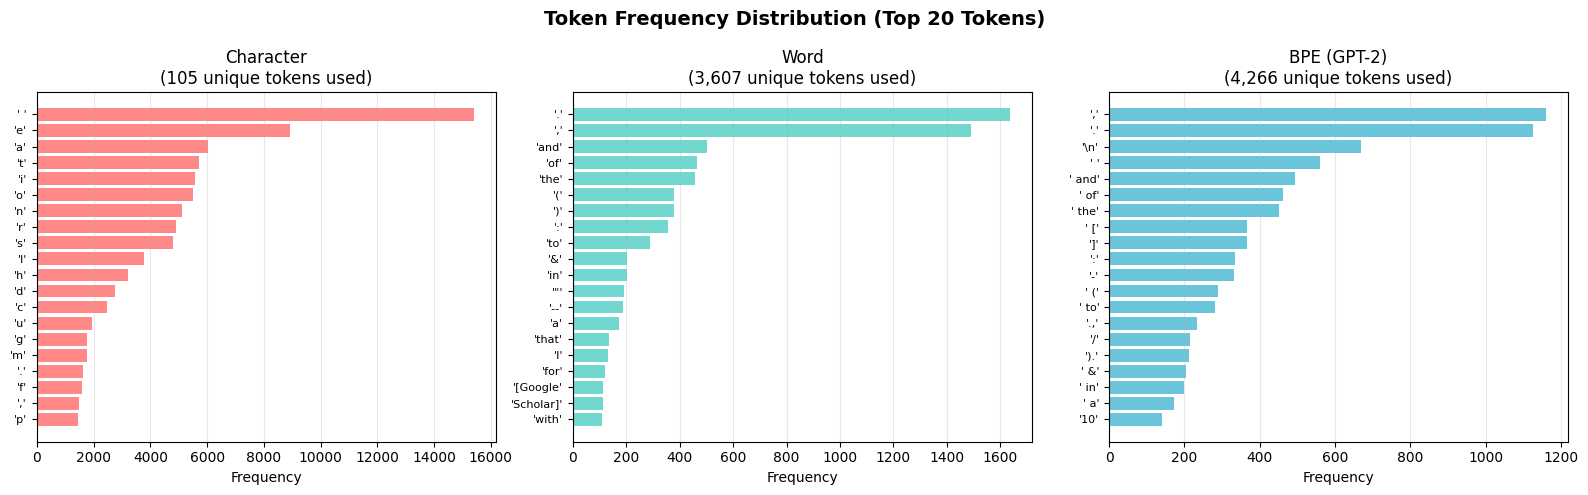

In [38]:
def get_token_frequencies(tokenizer, text, name, top_n=20):
    """Get frequency distribution of tokens."""
    tokens = tokenize_text(tokenizer, text, name)
    freq = Counter(tokens)
    
    # Get top N tokens with their string representations
    top_tokens = freq.most_common(top_n)
    
    if name == "BPE (GPT-2)":
        labels = [tokenizer.decode([t]) for t, _ in top_tokens]
    else:
        labels = [tokenizer.int_to_str.get(t, '<?>') for t, _ in top_tokens]
    
    counts = [c for _, c in top_tokens]
    return labels, counts, len(set(tokens))

# Analyze token frequency distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Token Frequency Distribution (Top 20 Tokens)', fontsize=14, fontweight='bold')

# Use combined corpus for distribution analysis
for idx, (tok_name, tokenizer) in enumerate(tokenizers.items()):
    labels, counts, unique_count = get_token_frequencies(tokenizer, combined_corpus, tok_name)
    
    ax = axes[idx]
    bars = ax.barh(range(len(labels)), counts, color=colors[tok_name], alpha=0.8)
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels([repr(l)[:15] for l in labels], fontsize=8)
    ax.invert_yaxis()  # Most frequent at top
    ax.set_xlabel('Frequency')
    ax.set_title(f'{tok_name}\n({unique_count:,} unique tokens used)')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Token Length Distribution

Compare how long the individual tokens are for each method (in characters).

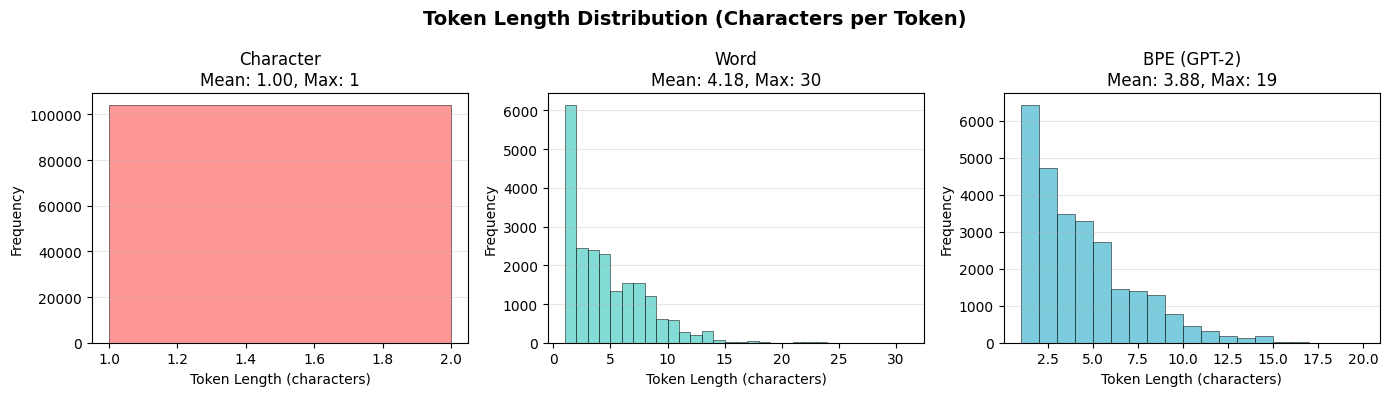

In [39]:
def get_token_lengths(tokenizer, text, name):
    """Get the length (in characters) of each token."""
    tokens = tokenize_text(tokenizer, text, name)
    
    if name == "BPE (GPT-2)":
        lengths = [len(tokenizer.decode([t])) for t in tokens]
    else:
        lengths = [len(tokenizer.int_to_str.get(t, '')) for t in tokens]
    
    return lengths

# Get token lengths for each tokenizer
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Token Length Distribution (Characters per Token)', fontsize=14, fontweight='bold')

for idx, (tok_name, tokenizer) in enumerate(tokenizers.items()):
    lengths = get_token_lengths(tokenizer, combined_corpus, tok_name)
    
    ax = axes[idx]
    ax.hist(lengths, bins=range(1, max(lengths)+2), color=colors[tok_name], 
            alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.set_xlabel('Token Length (characters)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{tok_name}\nMean: {np.mean(lengths):.2f}, Max: {max(lengths)}')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary Statistics

Final comparison table with all key metrics.

In [40]:
# Create summary statistics
summary_data = []

for tok_name, tokenizer in tokenizers.items():
    tokens = tokenize_text(tokenizer, combined_corpus, tok_name)
    unique_tokens = len(set(tokens))
    
    summary_data.append({
        'Tokenizer': tok_name,
        'Vocabulary Size': get_vocab_size(tokenizer, tok_name),
        'Tokens in Corpus': len(tokens),
        'Unique Tokens Used': unique_tokens,
        'Vocab Coverage (%)': (unique_tokens / get_vocab_size(tokenizer, tok_name)) * 100,
        'Avg Compression': len(combined_corpus) / len(tokens),
        'OOV Handling': 'N/A (byte-level)' if tok_name == 'BPE (GPT-2)' else '<|unk|> token'
    })

summary_df = pd.DataFrame(summary_data)
summary_df['Vocabulary Size'] = summary_df['Vocabulary Size'].apply(lambda x: f'{x:,}')
summary_df['Tokens in Corpus'] = summary_df['Tokens in Corpus'].apply(lambda x: f'{x:,}')
summary_df['Unique Tokens Used'] = summary_df['Unique Tokens Used'].apply(lambda x: f'{x:,}')
summary_df['Vocab Coverage (%)'] = summary_df['Vocab Coverage (%)'].apply(lambda x: f'{x:.2f}%')
summary_df['Avg Compression'] = summary_df['Avg Compression'].apply(lambda x: f'{x:.2f} chars/token')

print("=== Summary: Tokenization Methods Comparison ===\n")
display(summary_df.set_index('Tokenizer').T)

=== Summary: Tokenization Methods Comparison ===



Tokenizer,Character,Word,BPE (GPT-2)
Vocabulary Size,106,"3,609","50,257"
Tokens in Corpus,"104,152","21,079","26,888"
Unique Tokens Used,105,"3,607","4,266"
Vocab Coverage (%),99.06%,99.94%,8.49%
Avg Compression,1.00 chars/token,4.94 chars/token,3.87 chars/token
OOV Handling,<|unk|> token,<|unk|> token,N/A (byte-level)


---

## Key Findings

### Character Tokenizer
- **Vocabulary**: Smallest vocabulary (only unique characters)
- **Sequence Length**: Longest sequences (one token per character)
- **Compression**: Lowest (1 char/token)
- **OOV**: Rarely encounters OOV if character set is complete

### Word Tokenizer
- **Vocabulary**: Medium-sized vocabulary (unique words)
- **Sequence Length**: Shorter than character-level
- **Compression**: Moderate (depends on avg word length)
- **OOV**: Uses `<|unk|>` token for unknown words

### BPE Tokenizer (GPT-2)
- **Vocabulary**: Large pre-trained vocabulary (50,257 tokens)
- **Sequence Length**: Shortest sequences (best compression)
- **Compression**: Highest efficiency
- **OOV**: No OOV issues - can encode any byte sequence

### Trade-offs
- **Character**: Simple, small vocab, but very long sequences increase computational cost
- **Word**: Interpretable tokens, but OOV problems with rare/new words
- **BPE**: Best balance of vocabulary size and sequence length, handles all inputs

---

# Deep Dive: tiktoken (BPE) Analysis

tiktoken is OpenAI's fast BPE tokenizer used by GPT models. This section explores its capabilities in depth.

## Performance Comparison

Compare tiktoken's speed and efficiency against our custom tokenizers.

=== Performance Benchmark ===

Text length: 104,152 characters

Character:
  Encode: 4.834 ms
  Decode: 4.701 ms
  Throughput: 21,545,285 tokens/sec

Word:
  Encode: 8.733 ms
  Decode: 4.274 ms
  Throughput: 2,413,671 tokens/sec

BPE (GPT-2):
  Encode: 8.828 ms
  Decode: 0.877 ms
  Throughput: 3,045,636 tokens/sec



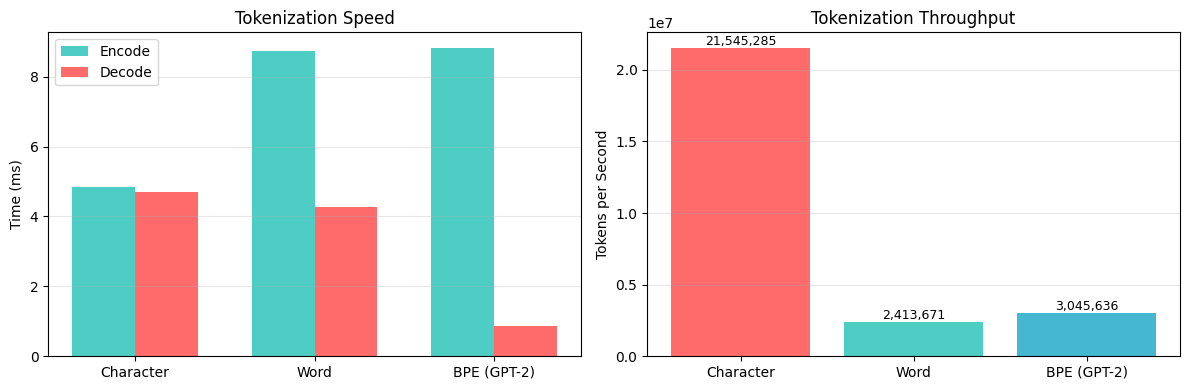

In [41]:
import time

def benchmark_tokenizer(tokenizer, text, name, iterations=100):
    """Benchmark tokenization speed."""
    # Warm up
    if name == "BPE (GPT-2)":
        tokenizer.encode(text)
    else:
        tokenizer.encode(text)
    
    # Time encoding
    start = time.perf_counter()
    for _ in range(iterations):
        if name == "BPE (GPT-2)":
            tokens = tokenizer.encode(text)
        else:
            tokens = tokenizer.encode(text)
    encode_time = (time.perf_counter() - start) / iterations * 1000  # ms
    
    # Time decoding
    start = time.perf_counter()
    for _ in range(iterations):
        if name == "BPE (GPT-2)":
            tokenizer.decode(tokens)
        else:
            tokenizer.decode(tokens)
    decode_time = (time.perf_counter() - start) / iterations * 1000  # ms
    
    return {
        'Tokenizer': name,
        'Encode Time (ms)': encode_time,
        'Decode Time (ms)': decode_time,
        'Tokens/sec': len(tokens) / (encode_time / 1000),
        'Token Count': len(tokens)
    }

# Benchmark on the combined corpus
print("=== Performance Benchmark ===\n")
print(f"Text length: {len(combined_corpus):,} characters\n")

benchmark_results = []
for tok_name, tokenizer in tokenizers.items():
    result = benchmark_tokenizer(tokenizer, combined_corpus, tok_name)
    benchmark_results.append(result)
    print(f"{tok_name}:")
    print(f"  Encode: {result['Encode Time (ms)']:.3f} ms")
    print(f"  Decode: {result['Decode Time (ms)']:.3f} ms")
    print(f"  Throughput: {result['Tokens/sec']:,.0f} tokens/sec\n")

# Visualize performance
bench_df = pd.DataFrame(benchmark_results)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axes[0]
x = range(len(bench_df))
width = 0.35
ax1.bar([i - width/2 for i in x], bench_df['Encode Time (ms)'], width, label='Encode', color='#4ECDC4')
ax1.bar([i + width/2 for i in x], bench_df['Decode Time (ms)'], width, label='Decode', color='#FF6B6B')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Tokenization Speed')
ax1.set_xticks(x)
ax1.set_xticklabels(bench_df['Tokenizer'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[1]
ax2.bar(bench_df['Tokenizer'], bench_df['Tokens/sec'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax2.set_ylabel('Tokens per Second')
ax2.set_title('Tokenization Throughput')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(bench_df['Tokens/sec']):
    ax2.text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Advantages of BPE Tokenization

BPE (Byte Pair Encoding) offers several key advantages over character and word-level tokenization:

In [44]:
# Demonstrate BPE advantages

print("=== BPE Tokenization Advantages ===\n")

# 1. Subword decomposition for unknown words
print("1. SUBWORD DECOMPOSITION")
print("-" * 50)
unknown_words = ["transformerization", "unbelievably", "cryptocurrency", "microprocessor"]
for word in unknown_words:
    tokens = bpe_tokenizer.encode(word)
    decoded = [bpe_tokenizer.decode([t]) for t in tokens]
    print(f"  '{word}' → {decoded}")
print()

# 2. Handling morphological variations
print("2. MORPHOLOGICAL VARIATIONS")
print("-" * 50)
morphs = [("run", "running", "runner", "runs"),
          ("happy", "unhappy", "happiness", "happily")]
for word_group in morphs:
    print(f"  Base: '{word_group[0]}'")
    for word in word_group:
        tokens = bpe_tokenizer.encode(word)
        decoded = [bpe_tokenizer.decode([t]) for t in tokens]
        print(f"    '{word}' → {decoded} ({len(tokens)} tokens)")
    print()

# 3. Efficient handling of common subwords
print("3. COMMON SUBWORD EFFICIENCY")
print("-" * 50)
common_suffixes = ["tion", "ing", "ed", "ly", "ment"]
for suffix in common_suffixes:
    tokens = bpe_tokenizer.encode(suffix)
    print(f"  '{suffix}' → token ID: {tokens} (single token: {len(tokens) == 1})")
print()

# 4. No OOV tokens - handles any byte sequence
print("4. NO OUT-OF-VOCABULARY TOKENS")
print("-" * 50)
unusual_inputs = [
    "🚀🌟💻",  # Emojis
    "café naïve résumé",  # Accented characters
    "日本語テスト",  # Japanese
    "مرحبا",  # Arabic
    "12345!@#$%",  # Numbers and symbols
]
for text in unusual_inputs:
    tokens = bpe_tokenizer.encode(text)
    roundtrip = bpe_tokenizer.decode(tokens)
    status = "✓" if roundtrip == text else "✗"
    print(f"  {status} '{text}' → {len(tokens)} tokens, roundtrip: '{roundtrip}'")

=== BPE Tokenization Advantages ===

1. SUBWORD DECOMPOSITION
--------------------------------------------------
  'transformerization' → ['trans', 'former', 'ization']
  'unbelievably' → ['un', 'bel', 'iev', 'ably']
  'cryptocurrency' → ['crypt', 'oc', 'urrency']
  'microprocessor' → ['micro', 'processor']

2. MORPHOLOGICAL VARIATIONS
--------------------------------------------------
  Base: 'run'
    'run' → ['run'] (1 tokens)
    'running' → ['running'] (1 tokens)
    'runner' → ['runner'] (1 tokens)
    'runs' → ['runs'] (1 tokens)

  Base: 'happy'
    'happy' → ['happy'] (1 tokens)
    'unhappy' → ['un', 'happy'] (2 tokens)
    'happiness' → ['h', 'appiness'] (2 tokens)
    'happily' → ['h', 'app', 'ily'] (3 tokens)

3. COMMON SUBWORD EFFICIENCY
--------------------------------------------------
  'tion' → token ID: [5378] (single token: True)
  'ing' → token ID: [278] (single token: True)
  'ed' → token ID: [276] (single token: True)
  'ly' → token ID: [306] (single token: True)

---

## Special Tokens

Special tokens are reserved tokens with specific meanings (e.g., end-of-text, padding, unknown). Let's see how each tokenizer handles them.

In [45]:
print("=== Special Token Handling ===\n")

# 1. Our Word Tokenizer special tokens
print("1. WORD TOKENIZER SPECIAL TOKENS")
print("-" * 50)
print(f"  Available special tokens in vocabulary:")
special_word_tokens = [t for t in word_tokenizer.str_to_int.keys() if t.startswith("<|")]
for token in special_word_tokens:
    print(f"    '{token}' → ID: {word_tokenizer.str_to_int[token]}")

# Test with special tokens
test_with_special = "Hello <|endoftext|> World"
encoded = word_tokenizer.encode(test_with_special)
decoded = word_tokenizer.decode(encoded)
print(f"\n  Input: '{test_with_special}'")
print(f"  Encoded: {encoded}")
print(f"  Decoded: '{decoded}'")
print()

# 2. tiktoken special tokens
print("2. TIKTOKEN (GPT-2) SPECIAL TOKENS")
print("-" * 50)
# GPT-2 has <|endoftext|> as a special token
special_tokens_info = {
    "<|endoftext|>": "End of text marker (ID: 50256)"
}
print("  Built-in special tokens:")
for token, desc in special_tokens_info.items():
    print(f"    {token}: {desc}")

# Encoding with special tokens allowed
text_with_eot = "Hello world<|endoftext|>New text"
try:
    # With allowed_special parameter
    encoded_special = bpe_tokenizer.encode(text_with_eot, allowed_special={"<|endoftext|>"})
    print(f"\n  Input: '{text_with_eot}'")
    print(f"  Encoded (special allowed): {encoded_special}")
    print(f"  Decoded: '{bpe_tokenizer.decode(encoded_special)}'")
    
    # Check if <|endoftext|> token (50256) is in the encoding
    if 50256 in encoded_special:
        print(f"  ✓ <|endoftext|> token (50256) found at position {encoded_special.index(50256)}")
except Exception as e:
    print(f"  Error: {e}")

print()

# 3. Character tokenizer - no special tokens by default
print("3. CHARACTER TOKENIZER SPECIAL TOKENS")
print("-" * 50)
print("  Character tokenizer has no built-in special tokens.")
print("  Special sequences are tokenized character by character:")
test_text = "<|endoftext|>"
char_encoded = char_tokenizer.encode(test_text)
print(f"  '{test_text}' → {len(char_encoded)} character tokens")

=== Special Token Handling ===

1. WORD TOKENIZER SPECIAL TOKENS
--------------------------------------------------
  Available special tokens in vocabulary:
    '<|endoftext|>' → ID: 3607
    '<|unk|>' → ID: 3608

  Input: 'Hello <|endoftext|> World'
  Encoded: [3608, 3607, 3608]
  Decoded: '<|unk|> <|endoftext|> <|unk|>'

2. TIKTOKEN (GPT-2) SPECIAL TOKENS
--------------------------------------------------
  Built-in special tokens:
    <|endoftext|>: End of text marker (ID: 50256)

  Input: 'Hello world<|endoftext|>New text'
  Encoded (special allowed): [15496, 995, 50256, 3791, 2420]
  Decoded: 'Hello world<|endoftext|>New text'
  ✓ <|endoftext|> token (50256) found at position 2

3. CHARACTER TOKENIZER SPECIAL TOKENS
--------------------------------------------------
  Character tokenizer has no built-in special tokens.
  Special sequences are tokenized character by character:
  '<|endoftext|>' → 13 character tokens


## Handling Unknown Words

How does each tokenizer deal with words not seen during vocabulary building?

In [46]:
print("=== Unknown Word Handling ===\n")

# Words unlikely to be in our training corpus
unknown_words_test = [
    "supercalifragilisticexpialidocious",  # Very long word
    "COVID-19",  # Modern term
    "iPhone15Pro",  # Product name
    "asdfghjkl",  # Random string
    "Übermensch",  # German word with umlaut
]

print(f"{'Word':<40} {'Character':<15} {'Word Tok':<15} {'BPE':<15}")
print("=" * 85)

for word in unknown_words_test:
    # Character tokenizer - always works
    char_tokens = char_tokenizer.encode(word)
    char_result = f"{len(char_tokens)} chars"
    
    # Word tokenizer - may produce <|unk|>
    word_tokens = word_tokenizer.encode(word)
    unk_id = word_tokenizer.str_to_int.get("<|unk|>")
    unk_count = word_tokens.count(unk_id) if unk_id else 0
    if unk_count > 0:
        word_result = f"{unk_count} UNK"
    else:
        word_result = f"{len(word_tokens)} tokens"
    
    # BPE tokenizer - subword decomposition
    bpe_tokens = bpe_tokenizer.encode(word)
    bpe_result = f"{len(bpe_tokens)} subwords"
    
    print(f"{word:<40} {char_result:<15} {word_result:<15} {bpe_result:<15}")

print("\n" + "=" * 85)
print("\nDetailed BPE breakdown of unknown words:")
for word in unknown_words_test[:3]:
    tokens = bpe_tokenizer.encode(word)
    decoded = [bpe_tokenizer.decode([t]) for t in tokens]
    print(f"  '{word}' → {decoded}")

=== Unknown Word Handling ===

Word                                     Character       Word Tok        BPE            
supercalifragilisticexpialidocious       34 chars        1 UNK           11 subwords    
COVID-19                                 8 chars         1 UNK           4 subwords     
iPhone15Pro                              11 chars        1 UNK           3 subwords     
asdfghjkl                                9 chars         1 UNK           5 subwords     
Übermensch                               10 chars        1 UNK           5 subwords     


Detailed BPE breakdown of unknown words:
  'supercalifragilisticexpialidocious' → ['super', 'cal', 'if', 'rag', 'il', 'ist', 'ice', 'xp', 'ial', 'id', 'ocious']
  'COVID-19' → ['CO', 'VID', '-', '19']
  'iPhone15Pro' → ['iPhone', '15', 'Pro']


## Multilingual Tokenization Comparison

Compare how each tokenizer handles text in different languages. This reveals limitations of tokenizers trained primarily on English text.

=== Multilingual Tokenization Analysis ===



,Language,Text,Characters,BPE Tokens,BPE Compression
0,English,"Hello, how are you today?",25,7,3.571429
1,Spanish,"Hola, ¿cómo estás hoy?",22,13,1.692308
2,French,"Bonjour, comment allez-vous?",28,10,2.800000
3,German,"Hallo, wie geht es Ihnen?",25,12,2.083333
4,Chinese,你好，你今天怎么样？,10,21,0.476190
5,Japanese,こんにちは、お元気ですか？,13,19,0.684211
6,Korean,"안녕하세요, 오늘 어떠세요?",15,34,0.441176
7,Russian,"Привет, как дела?",17,18,0.944444
8,Arabic,مرحبا، كيف حالك؟,16,20,0.800000
9,Hindi,"नमस्ते, आप कैसे हैं?",20,32,0.625000


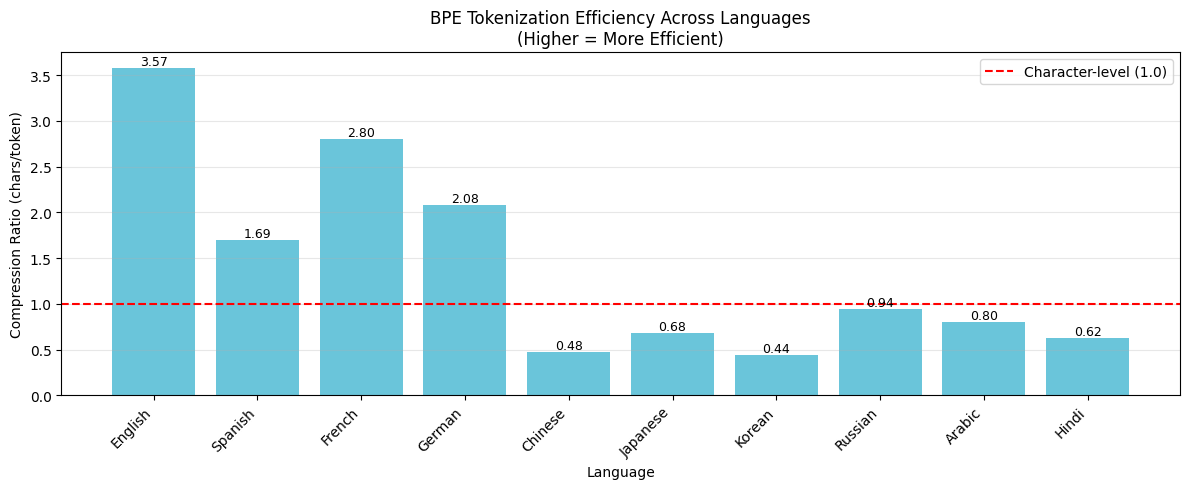


📊 Key Insight: BPE tokenizers trained on English have lower compression
   ratios for non-Latin scripts (Chinese, Japanese, Korean, Arabic, etc.)
   This means more tokens are needed, increasing computational cost.


In [47]:
print("=== Multilingual Tokenization Analysis ===\n")

# Sample texts in different languages (all saying approximately "Hello, how are you?")
multilingual_samples = {
    "English": "Hello, how are you today?",
    "Spanish": "Hola, ¿cómo estás hoy?",
    "French": "Bonjour, comment allez-vous?",
    "German": "Hallo, wie geht es Ihnen?",
    "Chinese": "你好，你今天怎么样？",
    "Japanese": "こんにちは、お元気ですか？",
    "Korean": "안녕하세요, 오늘 어떠세요?",
    "Russian": "Привет, как дела?",
    "Arabic": "مرحبا، كيف حالك؟",
    "Hindi": "नमस्ते, आप कैसे हैं?",
}

# Analyze tokenization efficiency across languages
results = []
for lang, text in multilingual_samples.items():
    char_len = len(text)
    
    # BPE tokenization
    bpe_tokens = bpe_tokenizer.encode(text)
    bpe_compression = char_len / len(bpe_tokens)
    
    # Character tokenization (always 1:1)
    char_compression = 1.0
    
    results.append({
        'Language': lang,
        'Text': text[:30] + "..." if len(text) > 30 else text,
        'Characters': char_len,
        'BPE Tokens': len(bpe_tokens),
        'BPE Compression': bpe_compression,
    })

multilingual_df = pd.DataFrame(results)
display(multilingual_df)

# Visualize compression ratio by language
fig, ax = plt.subplots(figsize=(12, 5))
languages = multilingual_df['Language']
x = np.arange(len(languages))

bars = ax.bar(x, multilingual_df['BPE Compression'], color='#45B7D1', alpha=0.8)
ax.axhline(y=1.0, color='red', linestyle='--', label='Character-level (1.0)')
ax.set_xlabel('Language')
ax.set_ylabel('Compression Ratio (chars/token)')
ax.set_title('BPE Tokenization Efficiency Across Languages\n(Higher = More Efficient)')
ax.set_xticks(x)
ax.set_xticklabels(languages, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, multilingual_df['BPE Compression']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.2f}', 
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 Key Insight: BPE tokenizers trained on English have lower compression")
print("   ratios for non-Latin scripts (Chinese, Japanese, Korean, Arabic, etc.)")
print("   This means more tokens are needed, increasing computational cost.")

In [48]:
# Detailed breakdown of multilingual tokenization
print("=== Detailed Multilingual Token Breakdown ===\n")

for lang, text in list(multilingual_samples.items())[:5]:
    tokens = bpe_tokenizer.encode(text)
    decoded = [bpe_tokenizer.decode([t]) for t in tokens]
    
    print(f"{lang}: '{text}'")
    print(f"  Tokens ({len(tokens)}): {decoded}")
    print()

=== Detailed Multilingual Token Breakdown ===

English: 'Hello, how are you today?'
  Tokens (7): ['Hello', ',', ' how', ' are', ' you', ' today', '?']

Spanish: 'Hola, ¿cómo estás hoy?'
  Tokens (13): ['H', 'ola', ',', ' �', '�', 'c', 'ó', 'mo', ' est', 'ás', ' h', 'oy', '?']

French: 'Bonjour, comment allez-vous?'
  Tokens (10): ['Bon', 'j', 'our', ',', ' comment', ' alle', 'z', '-', 'vous', '?']

German: 'Hallo, wie geht es Ihnen?'
  Tokens (12): ['Hall', 'o', ',', ' w', 'ie', ' ge', 'ht', ' es', ' I', 'hn', 'en', '?']

Chinese: '你好，你今天怎么样？'
  Tokens (21): ['�', '�', '�', '�', '�', '�', '�', '�', '�', '�', '�', '天', '�', '�', '�', '�', '�', '�', '�', '�', '�']



---

# Error Analysis

Analyzing tokenization errors and edge cases to understand failure modes and their impact on downstream NLP tasks.

## Cases Where Different Methods Fail

Each tokenization method has specific failure modes:

In [49]:
print("=== Tokenization Failure Cases ===\n")

# Test cases that expose weaknesses
edge_cases = {
    "Contractions": "I'm can't won't shouldn't've",
    "Hyphenated words": "state-of-the-art self-driving",
    "Numbers and units": "3.14159 $100.50 50kg 100°C",
    "URLs": "https://example.com/path?query=value",
    "Email": "user@example.com",
    "Code snippets": "def func(x): return x**2",
    "Mixed case": "iPhone MacBook GitHub",
    "Repeated chars": "Nooooooo!!! Hahahaha",
    "Whitespace": "Hello    World\t\tTab\n\nNewline",
    "Empty/special": "",
}

print("Testing edge cases across all tokenizers:\n")

for case_name, test_text in edge_cases.items():
    if not test_text:
        print(f"📌 {case_name}: (empty string)")
        print("   Character: 0 tokens")
        print("   Word: 0 tokens") 
        print("   BPE: 0 tokens")
        print()
        continue
        
    print(f"📌 {case_name}: '{test_text}'")
    
    # Character tokenizer
    char_tokens = char_tokenizer.encode(test_text)
    char_decoded = char_tokenizer.decode(char_tokens)
    char_match = "✓" if char_decoded == test_text else "✗"
    
    # Word tokenizer
    word_tokens = word_tokenizer.encode(test_text)
    word_decoded = word_tokenizer.decode(word_tokens)
    unk_id = word_tokenizer.str_to_int.get("<|unk|>")
    unk_count = word_tokens.count(unk_id) if unk_id else 0
    word_match = "✓" if word_decoded == test_text else f"✗ ({unk_count} UNK)"
    
    # BPE tokenizer
    bpe_tokens = bpe_tokenizer.encode(test_text)
    bpe_decoded = bpe_tokenizer.decode(bpe_tokens)
    bpe_match = "✓" if bpe_decoded == test_text else "✗"
    
    print(f"   Character: {len(char_tokens):3d} tokens, roundtrip: {char_match}")
    print(f"   Word:      {len(word_tokens):3d} tokens, roundtrip: {word_match}")
    print(f"   BPE:       {len(bpe_tokens):3d} tokens, roundtrip: {bpe_match}")
    print()

=== Tokenization Failure Cases ===

Testing edge cases across all tokenizers:

📌 Contractions: 'I'm can't won't shouldn't've'
   Character:  28 tokens, roundtrip: ✓
   Word:       14 tokens, roundtrip: ✗ (2 UNK)
   BPE:         9 tokens, roundtrip: ✓

📌 Hyphenated words: 'state-of-the-art self-driving'
   Character:  29 tokens, roundtrip: ✓
   Word:        2 tokens, roundtrip: ✗ (2 UNK)
   BPE:        10 tokens, roundtrip: ✓

📌 Numbers and units: '3.14159 $100.50 50kg 100°C'
   Character:  26 tokens, roundtrip: ✗
   Word:        8 tokens, roundtrip: ✗ (4 UNK)
   BPE:        13 tokens, roundtrip: ✓

📌 URLs: 'https://example.com/path?query=value'
   Character:  36 tokens, roundtrip: ✓
   Word:        7 tokens, roundtrip: ✗ (4 UNK)
   BPE:        11 tokens, roundtrip: ✓

📌 Email: 'user@example.com'
   Character:  16 tokens, roundtrip: ✗
   Word:        3 tokens, roundtrip: ✗ (2 UNK)
   BPE:         5 tokens, roundtrip: ✓

📌 Code snippets: 'def func(x): return x**2'
   Character:  24 token

## Impact on Downstream Tasks

Tokenization choices affect model performance in various NLP tasks:

In [50]:
print("=== Impact of Tokenization on Downstream Tasks ===\n")

# Simulate impact scenarios
impact_analysis = """
┌─────────────────────────────────────────────────────────────────────────────────┐
│                    TOKENIZATION IMPACT ON NLP TASKS                             │
├─────────────────────┬───────────────────────────────────────────────────────────┤
│ TASK                │ IMPACT                                                    │
├─────────────────────┼───────────────────────────────────────────────────────────┤
│ Text Classification │ • Word-level: OOV words lose semantic meaning             │
│                     │ • Char-level: Long sequences may exceed model limits      │
│                     │ • BPE: Good balance, preserves subword semantics          │
├─────────────────────┼───────────────────────────────────────────────────────────┤
│ Named Entity        │ • Word-level: Entities split incorrectly (New|York)       │
│ Recognition         │ • Char-level: Hard to learn word boundaries               │
│                     │ • BPE: May split entities (Micro|soft), needs alignment   │
├─────────────────────┼───────────────────────────────────────────────────────────┤
│ Machine             │ • Word-level: Large vocab, sparse embeddings              │
│ Translation         │ • Char-level: Too long sequences, slow training           │
│                     │ • BPE: Handles morphology well, good for agglutinative    │
├─────────────────────┼───────────────────────────────────────────────────────────┤
│ Sentiment Analysis  │ • Word-level: Negations may become UNK                    │
│                     │ • Char-level: Difficult to capture word-level sentiment   │
│                     │ • BPE: Preserves sentiment-bearing morphemes (-less, un-) │
├─────────────────────┼───────────────────────────────────────────────────────────┤
│ Code Generation     │ • Word-level: Syntax tokens split incorrectly             │
│                     │ • Char-level: Very long sequences for code                │
│                     │ • BPE: Learns common patterns (def, return, class)        │
└─────────────────────┴───────────────────────────────────────────────────────────┘
"""
print(impact_analysis)

# Concrete example: Sentiment analysis impact
print("Concrete Example - Sentiment Words:")
sentiment_words = ["unhappy", "disappointed", "unbelievable", "incredible"]

for word in sentiment_words:
    bpe_tokens = bpe_tokenizer.encode(word)
    bpe_parts = [bpe_tokenizer.decode([t]) for t in bpe_tokens]
    
    word_tokens = word_tokenizer.encode(word)
    is_unk = word_tokenizer.str_to_int.get("<|unk|>") in word_tokens
    
    print(f"  '{word}':")
    print(f"    BPE breakdown: {bpe_parts}")
    print(f"    Word tokenizer: {'<UNK>' if is_unk else 'known'}")
    print()

=== Impact of Tokenization on Downstream Tasks ===


┌─────────────────────────────────────────────────────────────────────────────────┐
│                    TOKENIZATION IMPACT ON NLP TASKS                             │
├─────────────────────┬───────────────────────────────────────────────────────────┤
│ TASK                │ IMPACT                                                    │
├─────────────────────┼───────────────────────────────────────────────────────────┤
│ Text Classification │ • Word-level: OOV words lose semantic meaning             │
│                     │ • Char-level: Long sequences may exceed model limits      │
│                     │ • BPE: Good balance, preserves subword semantics          │
├─────────────────────┼───────────────────────────────────────────────────────────┤
│ Named Entity        │ • Word-level: Entities split incorrectly (New|York)       │
│ Recognition         │ • Char-level: Hard to learn word boundaries               │
│                     │

## Suggested Improvements for Each Method

In [51]:
print("=== Suggested Improvements ===\n")

improvements = """
╔═══════════════════════════════════════════════════════════════════════════════════╗
║                         CHARACTER TOKENIZER IMPROVEMENTS                          ║
╠═══════════════════════════════════════════════════════════════════════════════════╣
║ 1. Add character n-grams (bigrams, trigrams) to capture common patterns           ║
║ 2. Implement character-level attention to learn word boundaries                   ║
║ 3. Add special tokens for whitespace normalization                                ║
║ 4. Consider byte-level encoding for full Unicode support                          ║
║ 5. Use character convolutions to reduce effective sequence length                 ║
╚═══════════════════════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════════════════════════════════════════╗
║                           WORD TOKENIZER IMPROVEMENTS                             ║
╠═══════════════════════════════════════════════════════════════════════════════════╣
║ 1. Implement subword fallback for OOV words (hybrid approach)                     ║
║ 2. Add stemming/lemmatization to reduce vocabulary size                           ║
║ 3. Use word embeddings to handle similar unknown words                            ║
║ 4. Implement domain-specific vocabulary expansion                                 ║
║ 5. Add regex patterns for URLs, emails, numbers, and other special formats        ║
║ 6. Consider case normalization with case features preserved separately            ║
╚═══════════════════════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════════════════════════════════════════╗
║                           BPE TOKENIZER IMPROVEMENTS                              ║
╠═══════════════════════════════════════════════════════════════════════════════════╣
║ 1. Train on multilingual corpus for better non-English support                    ║
║ 2. Add domain-specific merge rules (code, medical, legal)                         ║
║ 3. Implement dynamic vocabulary expansion for new terms                           ║
║ 4. Use SentencePiece for language-agnostic tokenization                           ║
║ 5. Consider Unigram LM or WordPiece as alternatives                               ║
║ 6. Add token dropout during training for robustness                               ║
╚═══════════════════════════════════════════════════════════════════════════════════╝
"""
print(improvements)

=== Suggested Improvements ===


╔═══════════════════════════════════════════════════════════════════════════════════╗
║                         CHARACTER TOKENIZER IMPROVEMENTS                          ║
╠═══════════════════════════════════════════════════════════════════════════════════╣
║ 1. Add character n-grams (bigrams, trigrams) to capture common patterns           ║
║ 2. Implement character-level attention to learn word boundaries                   ║
║ 3. Add special tokens for whitespace normalization                                ║
║ 4. Consider byte-level encoding for full Unicode support                          ║
║ 5. Use character convolutions to reduce effective sequence length                 ║
╚═══════════════════════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════════════════════════════════════════╗
║                           WORD TOKENIZER IMPROVEMENTS                             ║
╠═══════════════════

## Trade-offs Discussion

=== Trade-offs Between Tokenization Approaches ===

       Criterion Character  Word   BPE
 Vocabulary Size     ★★★★★ ★★☆☆☆ ★★★☆☆
 Sequence Length     ★☆☆☆☆ ★★★★☆ ★★★★★
    OOV Handling     ★★★★★ ★☆☆☆☆ ★★★★★
  Training Speed     ★★☆☆☆ ★★★★☆ ★★★☆☆
 Inference Speed     ★★☆☆☆ ★★★★☆ ★★★★★
    Memory Usage     ★★★★★ ★★☆☆☆ ★★★☆☆
    Multilingual     ★★★★★ ★★☆☆☆ ★★★☆☆
Interpretability     ★★★★☆ ★★★★★ ★★★☆☆
  Implementation     ★★★★★ ★★★★☆ ★★☆☆☆
      Morphology     ★☆☆☆☆ ★★☆☆☆ ★★★★★


★ Rating Scale: ★☆☆☆☆ (Poor) to ★★★★★ (Excellent)

Key Trade-off Insights:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. VOCABULARY vs SEQUENCE LENGTH
   • Character: Small vocab but very long sequences → memory efficient, compute expensive
   • Word: Large vocab but short sequences → memory expensive, compute efficient
   • BPE: Balanced approach → moderate on both

2. OOV HANDLING vs INTERPRETABILITY
   • Character: Handles any input but tokens lack semantic meaning
   

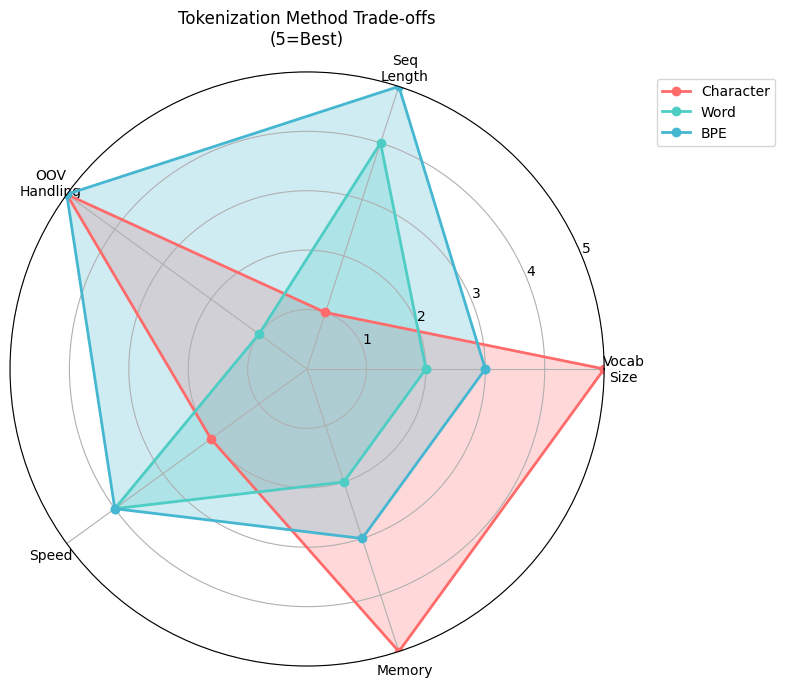

In [52]:
print("=== Trade-offs Between Tokenization Approaches ===\n")

# Create a trade-off comparison matrix
tradeoffs = {
    'Criterion': [
        'Vocabulary Size',
        'Sequence Length', 
        'OOV Handling',
        'Training Speed',
        'Inference Speed',
        'Memory Usage',
        'Multilingual',
        'Interpretability',
        'Implementation',
        'Morphology'
    ],
    'Character': ['★★★★★', '★☆☆☆☆', '★★★★★', '★★☆☆☆', '★★☆☆☆', '★★★★★', '★★★★★', '★★★★☆', '★★★★★', '★☆☆☆☆'],
    'Word': ['★★☆☆☆', '★★★★☆', '★☆☆☆☆', '★★★★☆', '★★★★☆', '★★☆☆☆', '★★☆☆☆', '★★★★★', '★★★★☆', '★★☆☆☆'],
    'BPE': ['★★★☆☆', '★★★★★', '★★★★★', '★★★☆☆', '★★★★★', '★★★☆☆', '★★★☆☆', '★★★☆☆', '★★☆☆☆', '★★★★★']
}

tradeoff_df = pd.DataFrame(tradeoffs)
print(tradeoff_df.to_string(index=False))

print("""
\n★ Rating Scale: ★☆☆☆☆ (Poor) to ★★★★★ (Excellent)

Key Trade-off Insights:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. VOCABULARY vs SEQUENCE LENGTH
   • Character: Small vocab but very long sequences → memory efficient, compute expensive
   • Word: Large vocab but short sequences → memory expensive, compute efficient
   • BPE: Balanced approach → moderate on both

2. OOV HANDLING vs INTERPRETABILITY
   • Character: Handles any input but tokens lack semantic meaning
   • Word: Meaningful tokens but fails on unknown words
   • BPE: Subwords preserve some meaning while handling OOV

3. SPEED vs FLEXIBILITY
   • Pre-trained BPE: Fast inference but fixed vocabulary
   • Custom tokenizers: Flexible but need retraining for new domains

4. SIMPLICITY vs PERFORMANCE
   • Character: Simplest to implement, hardest for models to learn from
   • BPE: Complex training process, best downstream performance
""")

# Visualize trade-offs as radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

categories = ['Vocab\nSize', 'Seq\nLength', 'OOV\nHandling', 'Speed', 'Memory']
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the circle

# Convert star ratings to numbers (for visualization subset)
def stars_to_num(s):
    return s.count('★')

char_values = [5, 1, 5, 2, 5] + [5]  # +first value to close
word_values = [2, 4, 1, 4, 2] + [2]
bpe_values = [3, 5, 5, 4, 3] + [3]

ax.plot(angles, char_values, 'o-', linewidth=2, label='Character', color='#FF6B6B')
ax.fill(angles, char_values, alpha=0.25, color='#FF6B6B')

ax.plot(angles, word_values, 'o-', linewidth=2, label='Word', color='#4ECDC4')
ax.fill(angles, word_values, alpha=0.25, color='#4ECDC4')

ax.plot(angles, bpe_values, 'o-', linewidth=2, label='BPE', color='#45B7D1')
ax.fill(angles, bpe_values, alpha=0.25, color='#45B7D1')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 5)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.set_title('Tokenization Method Trade-offs\n(5=Best)', pad=20)

plt.tight_layout()
plt.show()